import

In [ ]:
import cv2
import base64
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.stats import qmc, rankdata, t as t_dist

from IPython.display import HTML, display
from matplotlib.ticker import LogLocator, LogFormatterMathtext, NullFormatter
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

from google.colab import files
from google.colab import output
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Common Function

In [ ]:
def solve_segment(f_ivp, state, t_eval, rtol=1e-6, atol=1e-9, method="RK45"):
    sol = solve_ivp(
        f_ivp,
        (float(t_eval[0]), float(t_eval[-1])),
        np.array(state, dtype=float),
        t_eval=np.array(t_eval, dtype=float),
        rtol=rtol,
        atol=atol,
        method=method,
    )
    if not sol.success:
        raise RuntimeError(sol.message)
    return sol.y.T


In [ ]:
def happen_event(solution, event_id):
    event_list = [
        [[solution[-1, 0], solution[-1, 1]]],          # 0: identity
        [[1, 0]],                                      # 1: B=1, MA=0
        [[solution[-1, 0]*0.5, solution[-1, 1]*0.5]],  # 2: B*0.5, MA*0.5
        [[solution[-1, 0], 0]],                        # 3: MA = 0
        [[solution[-1, 0], solution[-1, 1]*0.5]],      # 4: MA*0.5
        [[1, solution[-1, 1]]],                        # 5: B = 1
        [[solution[-1, 0]*0.5, solution[-1, 1]]]       # 6: B*0.5
    ]
    return event_list[event_id]

In [ ]:
def simulate_with_events(
    f_ivp, state0, t_within_event, event_ids,
    rtol=1e-6, atol=1e-9, method="RK45",
):
    state = np.array(state0, dtype=float)
    time_evolution = np.empty((0, 2), dtype=float)

    for eid in event_ids:
        sol = solve_segment(f_ivp, state, t_within_event, rtol=rtol, atol=atol, method=method)

        event_state = np.array(happen_event(sol, eid)[0], dtype=float)
        sol[-1] = event_state

        time_evolution = np.append(time_evolution, sol, axis=0)
        state = sol[-1]

    return time_evolution, state

Model

In [ ]:
def make_system_ivp(params):
    r, a, b, p, q = params["r"], params["a"], params["b"], params["p"], params["q"]

    def f(t, y):
        B, MA = y
        K = a * (1 - MA) + b * MA
        dBdt = r * B * (1 - B / K)
        dMAdt = -q * MA + p * (B/K) * (1 - MA)
        return np.array([dBdt, dMAdt], dtype=float)

    return f

In [ ]:
params_base = { 'r' : 1.31,
                'a' : 390,
                'b' : 1025,
                'p' : 0.030,
                'q' : 0.032 }

f_ivp_base = make_system_ivp(params_base)

In [ ]:
initial_state = [1.0, 0.0]
t = np.linspace(0, 200, 2000)
solution = solve_segment(f_ivp_base, initial_state, t)

nullcline

In [ ]:
def nullclines(x_range, y_range):
    B, MA = np.meshgrid(x_range, y_range)
    para = { 'r' : 1.31,
             'a' : 390 ,
             'b' : 1025,
             'p' : 0.030 ,
             'q' : 0.032 }
    dbdt  = para['r'] * B * (1-B/(para['a']*(1-MA)+para['b']*MA))
    dmdt  = -1 * para['q'] * MA + para['p'] * (B/(para['a']*(1-MA)+para['b']*MA)) * (1-MA)

    dxdt = dbdt
    dydt = dmdt
    X = B
    Y = MA

    return X, Y, dxdt, dydt

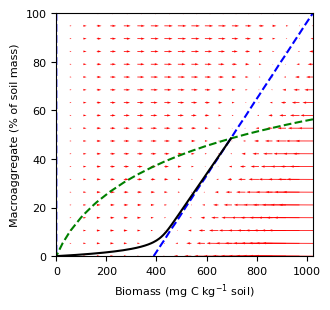

In [ ]:
# Figure setting
mm_to_inch = 1 / 25.4
figsize_inch = (85 * mm_to_inch, 80 * mm_to_inch)
plt.rcParams['font.size'] = 8

# Data
x_range = np.linspace(0, 1025, 20) # maxK
y_range = np.linspace(0, 1.0, 20)

X, Y, dxdt, dydt = nullclines(x_range, y_range)
Y_pct = 100 * Y
dydt_pct = 100 * dydt
solution_pct = solution.copy()
solution_pct[:, 1] *= 100

# Plot
fig, ax = plt.subplots(figsize=figsize_inch,linewidth=2)
ax.quiver(X, Y_pct, dxdt, dydt_pct, color='r')                          # Vector field
ax.contour(X, Y_pct, dxdt, levels=[0], colors='b', linestyles='dashed') # Nullclines
ax.contour(X, Y_pct, dydt, levels=[0], colors='g', linestyles='dashed')

ax.plot(
    solution[:, 0],
    solution_pct[:, 1],
    'k-',
    label='Trajectory'
)

ax.set_xlabel(r'Biomass (mg C kg$^{-1}$ soil)')
ax.set_ylabel('Macroaggregate (% of soil mass)')
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Fractal Interaction/Save/fig/nullcline_vectorfield.png',dpi=300)
plt.show()

### sensitive analysis for offset

In [ ]:
def estimate_Tconv_noevent(
    f_ivp, state0,
    dt_check=0.5,
    t_max=5000.0,
    tol=1e-3,
    window=5,
    B_scale=None,
    MA_scale=1.0,
    rtol=1e-6, atol=1e-9, method="RK45",
):
    n_steps = int(np.floor(t_max / dt_check))
    t_grid = np.linspace(0.0, n_steps * dt_check, n_steps + 1)

    sol = solve_ivp(
        f_ivp,
        (float(t_grid[0]), float(t_grid[-1])),
        np.array(state0, dtype=float),
        t_eval=t_grid,
        rtol=rtol,
        atol=atol,
        method=method,
    )
    if not sol.success:
        raise RuntimeError(sol.message)

    Y = sol.y.T

    if B_scale is None:
        B_scale = 1.0

    stable = 0
    for k in range(len(t_grid)):
        B, MA = Y[k]
        dBdt, dMAdt = f_ivp(t_grid[k], Y[k])

        crit_B = abs(dBdt) / (abs(B) + B_scale)
        crit_MA = abs(dMAdt) / (abs(MA) + MA_scale)
        crit = max(crit_B, crit_MA)

        if crit < tol:
            stable += 1
            if stable >= window:
                return float(t_grid[k]), Y[k].copy(), True
        else:
            stable = 0

    return float(t_grid[-1]), Y[-1].copy(), False

In [ ]:
def _max_metrics(traj):
    return float(np.max(traj[:, 0])), float(np.max(traj[:, 1]))

In [ ]:
def compute_metrics(
    params, state0,
    n_events,                 # number of events to run for offsets (e.g., 10)
    dt_check=0.5,             # sampling interval for Tconv estimation
    t_max=500.0,              # max time for Tconv estimation
    tol_conv=1e-6,            # convergence threshold for Tconv estimation
    window=5,                 # consecutive hits for Tconv estimation
    eps=1e-12,                # stabilizer for relative offsets
    rtol=1e-6, atol=1e-9, method="RK45",
    disturbance_event_id=3,   # event_id used for disturbance
    Ttime=3.0,                # time scale for Tconv
    make_system_ivp_func=None, # New parameter to pass the system factory function
):
    """
    1) Estimate Tconv from undisturbed continuous-time dynamics (no events)
    2) Define Tevent = Tconv/3
    3) Define n_timepoints = Tevent * 10 (ceil, min 2) and build t_event
    4) Run n_events events for:
       - event0: all 0
       - event3: all disturbance_event_id
    5) Compute max_B/max_MA and relative offsets
    """
    if make_system_ivp_func is None:
        raise ValueError("make_system_ivp_func must be provided for compute_metrics")
    f_ivp = make_system_ivp_func(params)

    # --- Tconv (no event) ---
    B_scale = max(params["a"], params["b"])

    Tconv, _, converged = estimate_Tconv_noevent(
        f_ivp, state0,
        dt_check=dt_check, t_max=t_max,
        tol=tol_conv, window=window,
        B_scale=B_scale, MA_scale=1.0,
        rtol=rtol, atol=atol, method=method
    )

    Tevent = Tconv / Ttime
    if Tevent <= 0:
        raise ValueError("Estimated Tevent <= 0. Check dt_check/t_max/tol_conv/window.")

    # --- event internal grid: n_timepoints = Tevent * 10 ---
    n_timepoints = max(2, int(np.ceil(Tevent * 10.0)))
    t_event = np.linspace(0.0, Tevent, n_timepoints)

    # --- compare event0 vs eventX with equal number of events ---
    event_ids0 = [0] * int(n_events)
    event_ids3 = [disturbance_event_id] * int(n_events)

    tev0, _ = simulate_with_events(f_ivp, state0, t_event, event_ids0, rtol=rtol, atol=atol, method=method)
    tev3, _ = simulate_with_events(f_ivp, state0, t_event, event_ids3, rtol=rtol, atol=atol, method=method)

    B0, MA0 = _max_metrics(tev0)
    B3, MA3 = _max_metrics(tev3)

    return {
        # convergence/time scaling
        "Tconv": float(Tconv),
        "Tevent": float(Tevent),
        "n_timepoints": int(n_timepoints),
        "converged": bool(converged),

        # simulation setup
        "n_events": int(n_events),
        "dt_check": float(dt_check),
        "t_max": float(t_max),
        "tol_conv": float(tol_conv),
        "window": int(window),

        # metrics & offsets
        "max_B_event0": B0,
        "max_B_event3": B3,
        "offset_B": abs(B3 - B0) / (abs(B0) + eps),

        "max_MA_event0": MA0,
        "max_MA_event3": MA3,
        "offset_MA": abs(MA3 - MA0) / (abs(MA0) + eps),
    }

In [ ]:
def sweep_1d_df(param_name, param_list, base_params, state0, **metric_kwargs):
    rows = []
    for val in param_list:
        params = dict(base_params)
        params[param_name] = val
        rows.append({**params, **compute_metrics(params, state0, **metric_kwargs)})
    return pd.DataFrame(rows)

def sweep_2d_df_ab(a_list, b_list, base_params, state0, **metric_kwargs):
    rows = []
    for a in a_list:
        for b in b_list:
            if not (a < b):
                continue

            params = dict(base_params)
            params["a"] = a
            params["b"] = b

            rows.append({
                **params,
                **compute_metrics(params, state0, **metric_kwargs),
            })
    return pd.DataFrame(rows)

def sweep_2d_df_rpq(r_list, p_list, q_list, base_params, state0, **metric_kwargs):
    rows = []
    for r in r_list:
        for p in p_list:
            for q in q_list:

                params = dict(base_params)
                params["r"] = r
                params["p"] = p
                params["q"] = q

                rows.append({
                    **params,
                    **compute_metrics(params, state0, **metric_kwargs),
                })

    return pd.DataFrame(rows)

In [ ]:
def _edges(c):
    c = np.asarray(c, float)
    if c.size == 1:
        return np.array([c[0]-0.5, c[0]+0.5])
    d = np.diff(c)
    e = np.empty(c.size + 1)
    e[1:-1] = c[:-1] + d/2
    e[0], e[-1] = c[0]-d[0]/2, c[-1]+d[-1]/2
    return e

def heat(ax, df, x="a", y="b", v="offset_MA", *, vmin=None, vmax=None, cmap="viridis", x_log_scale=True, y_log_scale=True):
    tab = df.pivot_table(index=y, columns=x, values=v, aggfunc="mean")

    xs = np.sort(tab.columns.to_numpy(float))
    ys = np.sort(tab.index.to_numpy(float))
    z  = tab.reindex(index=ys, columns=xs).to_numpy(float)

    Xe, Ye = _edges(xs), _edges(ys)

    # Determine vmin and vmax automatically if not provided
    if vmin is None:
        vmin = np.nanmin(z)
    if vmax is None:
        vmax = np.nanmax(z)

    m = ax.pcolormesh(Xe, Ye, np.ma.masked_invalid(z),
                      shading="auto", vmin=vmin, vmax=vmax, cmap=cmap)

    if x_log_scale:
        ax.set_xscale("log")
        ax.xaxis.set_major_locator(LogLocator(base=10))
        ax.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))
        ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10))
        ax.xaxis.set_minor_formatter(NullFormatter())
    else:
        ax.set_xscale("linear")
        # Allow Matplotlib to automatically set "normal" linear ticks
        # Removed: ax.set_xticks([xs[0], xs[-1]]) and ax.set_xticklabels([f'{xs[0]:.0f}', f'{xs[-1]:.0f}'])

    if y_log_scale:
        ax.set_yscale("log")
        ax.yaxis.set_major_locator(LogLocator(base=10))
        ax.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))
        ax.yaxis.set_major_formatter(LogFormatterMathtext(base=10))
        ax.yaxis.set_minor_formatter(NullFormatter())
    else:
        ax.set_yscale("linear")
        # Allow Matplotlib to automatically set "normal" linear ticks
        # Removed: ax.set_yticks([ys[0], ys[-1]]) and ax.set_yticklabels([f'{ys[0]:.0f}', f'{ys[-1]:.0f}'])

    ax.tick_params(which="major", length=5, width=0.8)
    ax.tick_params(which="minor", length=3, width=0.6)

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    return m

In [ ]:
# Initial state
state0 = [1.0, 0.0]

# Base parameters
base_params = {
    "r": 1.31,
    "a": 390,
    "b": 1025,
    "p": 0.03,
    "q": 0.032
}

metric_kwargs = dict(
    n_events=10,       # how many Tevent-long events to repeat for offsets
    dt_check=1,        # Tconv sampling interval
    t_max=5000.0,      # max time for Tconv search
    tol_conv=1e-3,     # Tconv threshold
    window=5,          # consecutive hits
    method="RK45",
    rtol=1e-6,
    atol=1e-9,
    disturbance_event_id=3,
    Ttime = 2,
    make_system_ivp_func=make_system_ivp # Use the correct system factory
)

# Single run (sanity check)
res = compute_metrics(base_params, state0, **metric_kwargs)

In [ ]:
res

{'Tconv': 58.0,
 'Tevent': 29.0,
 'n_timepoints': 290,
 'converged': True,
 'n_events': 10,
 'dt_check': 1.0,
 't_max': 5000.0,
 'tol_conv': 0.001,
 'window': 5,
 'max_B_event0': 697.258580213395,
 'max_B_event3': 643.2013816115903,
 'offset_B': 0.07752819418193543,
 'max_MA_event0': 0.48387096468066204,
 'max_MA_event3': 0.40223183902097626,
 'offset_MA': 0.16872086076377002}

In [ ]:
metric_kwargs_3 = metric_kwargs.copy()
metric_kwargs_3["disturbance_event_id"] = 3

metric_kwargs_4 = metric_kwargs.copy()
metric_kwargs_4["disturbance_event_id"] = 4

metric_kwargs_5 = metric_kwargs.copy()
metric_kwargs_5["disturbance_event_id"] = 5

metric_kwargs_6 = metric_kwargs.copy()
metric_kwargs_6["disturbance_event_id"] = 6

In [ ]:
a_list = np.linspace(23.31, 920, 20).tolist()
b_list = np.linspace(33.05, 1140, 20).tolist()

df_ab_event5 = sweep_2d_df_ab(a_list, b_list, base_params, state0, **metric_kwargs_5)

In [ ]:
r_list = [1.31]
p_list = np.logspace(np.log10(1e-4), np.log10(0.85), 20).tolist()
q_list = np.logspace(np.log10(1e-4), np.log10(0.1), 20).tolist()

df_pq_event5 = sweep_2d_df_rpq(r_list, p_list, q_list, base_params, state0, **metric_kwargs_5)

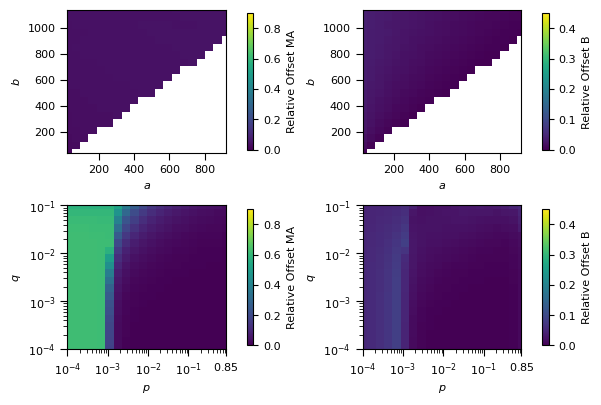

In [ ]:
# Figure settings
mm_to_in = 1/25.4
fig_w_mm = 150 # Total width
fig_h_mm = 100 # Total height
figsize_inch = (fig_w_mm * mm_to_in, fig_h_mm * mm_to_in)
plt.rcParams['font.size'] = 8

fig, axes = plt.subplots(2, 2, figsize=figsize_inch, constrained_layout=True)

# --- Common vmin/vmax for offset_MA across all relevant dataframes ---
all_ma_offsets = np.concatenate([
    df_ab_event5['offset_MA'].to_numpy(),
    df_pq_event5['offset_MA'].to_numpy()
])
vmin_ma, vmax_ma = 0, 0.9 # np.nanmin(all_ma_offsets), np.nanmax(all_ma_offsets)

# --- Common vmin/vmax for offset_B across all relevant dataframes ---
all_b_offsets = np.concatenate([
    df_ab_event5['offset_B'].to_numpy(),
    df_pq_event5['offset_B'].to_numpy()
])
vmin_b, vmax_b = 0, 0.45 # np.nanmin(all_b_offsets), np.nanmax(all_b_offsets)

# --- Top-Left: df_ab_event5, offset_MA (linear a, b) ---
ax00 = axes[0, 0]
m00 = heat(ax00, df_ab_event5, x='a', y='b', v='offset_MA', x_log_scale=False, y_log_scale=False, vmin=vmin_ma, vmax=vmax_ma)
cbar00 = fig.colorbar(m00, ax=ax00, shrink=0.95, label='Relative Offset MA')
ax00.set_xlim(df_ab_event5['a'].min(), df_ab_event5['a'].max())
ax00.set_ylim(df_ab_event5['b'].min(), df_ab_event5['b'].max())
ax00.xaxis.set_major_locator(ticker.MultipleLocator(200))
ax00.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax00.set_xlabel(r'$a$')
ax00.set_ylabel(r'$b$')

# --- Top-Right: df_ab_event5, offset_B (linear a, b) ---
ax01 = axes[0, 1]
m01 = heat(ax01, df_ab_event5, x='a', y='b', v='offset_B', x_log_scale=False, y_log_scale=False, vmin=vmin_b, vmax=vmax_b)
cbar01 = fig.colorbar(m01, ax=ax01, shrink=0.95, label='Relative Offset B')
ax01.set_xlim(df_ab_event5['a'].min(), df_ab_event5['a'].max())
ax01.set_ylim(df_ab_event5['b'].min(), df_ab_event5['b'].max())
ax01.xaxis.set_major_locator(ticker.MultipleLocator(200))
ax01.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax01.set_xlabel(r'$a$')
ax01.set_ylabel(r'$b$')

# --- Bottom-Left: df_pq_event5, offset_MA (log p, q) ---
ax10 = axes[1, 0]
m10 = heat(ax10, df_pq_event5, x='p', y='q', v='offset_MA', x_log_scale=True, y_log_scale=True, vmin=vmin_ma, vmax=vmax_ma)
cbar10 = fig.colorbar(m10, ax=ax10, shrink=0.95, label='Relative Offset MA')
ax10.set_xscale('log')
ax10.set_xlim(df_pq_event5['p'].min(), df_pq_event5['p'].max())
ax10.set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 0.85])
ax10.set_xticklabels([r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$0.85$'])
ax10.set_yscale('log')
ax10.set_ylim(df_pq_event5['q'].min(), df_pq_event5['q'].max())
ax10.set_xlabel(r'$p$')
ax10.set_ylabel(r'$q$')

# --- Bottom-Right: df_pq_event5, offset_B (log p, q) ---
ax11 = axes[1, 1]
m11 = heat(ax11, df_pq_event5, x='p', y='q', v='offset_B', x_log_scale=True, y_log_scale=True, vmin=vmin_b, vmax=vmax_b)
cbar11 = fig.colorbar(m11, ax=ax11, shrink=0.95, label='Relative Offset B')
ax11.set_xscale('log')
ax11.set_xlim(df_pq_event5['p'].min(), df_pq_event5['p'].max())
ax11.set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 0.85])
ax11.set_xticklabels([r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$0.85$'])
ax11.set_yscale('log')
ax11.set_ylim(df_pq_event5['q'].min(), df_pq_event5['q'].max())
ax11.set_xlabel(r'$p$')
ax11.set_ylabel(r'$q$')

plt.savefig('/content/drive/MyDrive/Fractal Interaction/Save/fig/heatmaps_ab_pq_event5.png', dpi=300)
plt.show()

In [ ]:
r_list = np.linspace(0.61, 9.19, 20).tolist()
p_list = [0.030]
q_list = [0.032]

df_r_event3 = sweep_2d_df_rpq(r_list, p_list, q_list, base_params, state0, **metric_kwargs_3)
df_r_event5 = sweep_2d_df_rpq(r_list, p_list, q_list, base_params, state0, **metric_kwargs_5)

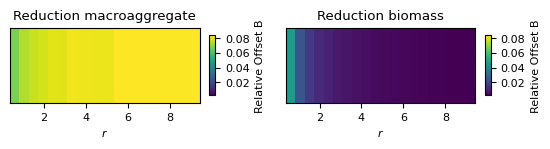

In [ ]:
def plot_1d_heatmap(ax, x_data, z_data, title, x_label, z_label, log_scale_x=False, cmap='viridis', vmin=None, vmax=None, x_ticks=None, x_ticklabels=None):
    # Sort data by x_data to ensure proper plotting with pcolormesh
    sort_idx = np.argsort(x_data)
    sorted_x_data = x_data[sort_idx]
    sorted_z_data = z_data[sort_idx]

    # Calculate bin edges for x-axis using the existing _edges function
    Xe = _edges(sorted_x_data)
    Ye = np.array([0, 1]) # Dummy y-axis for 1D heatmap

    # Reshape z_data for pcolormesh (needs to be 2D, e.g., (1, N) for a single strip)
    Z = np.array([sorted_z_data])

    if vmin is None:
        vmin = np.nanmin(Z)
    if vmax is None:
        vmax = np.nanmax(Z)

    m = ax.pcolormesh(Xe, Ye, np.ma.masked_invalid(Z),
                      shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_yticks([]) # Hide y-axis ticks as it's a dummy axis
    ax.set_ylabel('') # No y-axis label for the dummy axis

    if log_scale_x:
        ax.set_xscale("log")
        # Apply default log locators and formatters ONLY if custom ticks are not provided
        if x_ticks is None:
            ax.xaxis.set_major_locator(LogLocator(base=10))
            ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10))
            ax.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))
            ax.xaxis.set_minor_formatter(LogFormatterMathtext(base=10, labelOnlyBase=False))
    else:
        ax.set_xscale("linear")

    # Apply custom ticks if provided (after setting scale)
    if x_ticks is not None:
        ax.set_xticks(x_ticks)
    if x_ticklabels is not None:
        ax.set_xticklabels(x_ticklabels)
    # If custom ticks are provided for a log scale, ensure they are formatted nicely.
    # If labels are not explicitly provided, use LogFormatterMathtext for custom ticks as well.
    elif log_scale_x and x_ticks is not None and x_ticklabels is None:
        ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10))
        ax.xaxis.set_minor_formatter(LogFormatterMathtext(base=10, labelOnlyBase=False))

    return m

# Figure setting
mm_to_in = 1/25.4
fig_w_mm, fig_h_mm = 140, 35 # Adjusted height for single row
plt.rcParams["font.size"] = 8
# Set w_pad for constrained_layout before creating the figure
plt.rcParams['figure.constrained_layout.w_pad'] = 0.1 # Set w_pad to 0.1 for a slight horizontal gap

fig, axes = plt.subplots(
    1, 2, # Changed to 1 row, 2 columns
    figsize=(fig_w_mm*mm_to_in, fig_h_mm*mm_to_in),
    constrained_layout=True
)

# Common vmin/vmax for B offsets across all relevant event dataframes
all_ma_offsets = np.concatenate([
    df_r_event3['offset_B'].to_numpy(),
    df_r_event5['offset_B'].to_numpy()
])
vmin_ma, vmax_ma = np.nanmin(all_ma_offsets), np.nanmax(all_ma_offsets)

# --- Plot (0,0): df_r_event3, offset_B ---
ax0 = axes[0] # Access first subplot in the single row
m0 = plot_1d_heatmap(
    ax0,
    x_data=df_r_event3['r'].to_numpy(),
    z_data=df_r_event3['offset_B'].to_numpy(),
    title='Reduction macroaggregate',
    x_label=r'$r$', # Added x-label for the single row
    z_label='Relative Offset B',
    log_scale_x=False, # Changed to linear scale
    vmin=vmin_ma, vmax=vmax_ma
)
cb0 = fig.colorbar(m0, ax=ax0, shrink=0.8, aspect=10, label='Relative Offset B')
cb0.locator = plt.MaxNLocator(nbins=5)
cb0.update_ticks()
# ax0.set_xlim(r_list[0], r_list[-1]) # Removed for linear scale
# ax0.tick_params(labelbottom=False) # Removed as x-labels are now desired

# --- Plot (0,1): df_r_event5, offset_MA ---
ax1 = axes[1] # Access second subplot in the single row
m1 = plot_1d_heatmap(
    ax1,
    x_data=df_r_event5['r'].to_numpy(),
    z_data=df_r_event5['offset_B'].to_numpy(),
    title='Reduction biomass',
    x_label=r'$r$', # Added x-label for the single row
    z_label='Relative Offset B',
    log_scale_x=False, # Changed to linear scale
    vmin=vmin_ma, vmax=vmax_ma
)
cb1 = fig.colorbar(m1, ax=ax1, shrink=0.8, aspect=10, label='Relative Offset B')
cb1.locator = plt.MaxNLocator(nbins=5)
cb1.update_ticks()
# ax1.set_xlim(r_list[0], r_list[-1]) # Removed for linear scale
# ax1.tick_params(labelbottom=False) # Removed as x-labels are now desired

plt.savefig("/content/drive/MyDrive/Fractal Interaction/Save/fig/heatmaps_r_event3-5_b.png", dpi=300)
plt.show()

### grid search

In [ ]:
param_ranges = {
    "r": (0.61, 9.19),
    "a": (23.31, 920),
    "b": (33.05, 1140),
    "p": (0.001, 0.85),
    "q": (0.001, 0.1),
}
param_names = list(param_ranges.keys())

In [ ]:
def lhs_sample(n_samples: int, seed: int = 0):
    d = len(param_names)

    all_valid_samples = []
    current_seed = seed

    # Indices for 'a' and 'b' parameters
    a_idx = param_names.index('a')
    b_idx = param_names.index('b')

    # Log scaling parameters
    p_idx = param_names.index('p')
    q_idx = param_names.index('q')
    p_low_log = np.log10(param_ranges['p'][0])
    p_high_log = np.log10(param_ranges['p'][1])
    q_low_log = np.log10(param_ranges['q'][0])
    q_high_log = np.log10(param_ranges['q'][1])

    attempts = 0
    max_attempts = 100 # Safety break to prevent infinite loops

    while len(all_valid_samples) < n_samples and attempts < max_attempts:
        # Generate a batch of samples. Attempt to generate a larger batch to increase chances of finding valid samples.
        batch_size = max(n_samples * 2, 50) # Generate at least 2*n_samples or a minimum of 50

        # Re-initialize sampler with a new seed for each batch to ensure new LHS samples
        sampler = qmc.LatinHypercube(d=d, seed=current_seed)
        U_batch = sampler.random(n=batch_size) # (batch_size, d) in [0,1]

        # Scale to parameter ranges (linear first)
        lows = np.array([param_ranges[k][0] for k in param_names])
        highs = np.array([param_ranges[k][1] for k in param_names])
        X_batch = qmc.scale(U_batch, lows, highs)

        # Apply log scaling for 'p' and 'q'
        X_batch[:, p_idx] = 10**(qmc.scale(U_batch[:, p_idx].reshape(-1, 1), p_low_log, p_high_log)).flatten()
        X_batch[:, q_idx] = 10**(qmc.scale(U_batch[:, q_idx].reshape(-1, 1), q_low_log, q_high_log)).flatten()

        # Filter the batch for a < b
        for i in range(batch_size):
            current_a = X_batch[i, a_idx]
            current_b = X_batch[i, b_idx]
            if current_a < current_b:
                all_valid_samples.append(X_batch[i, :])

        current_seed += 1 # Increment seed for next iteration
        attempts += 1

    if len(all_valid_samples) < n_samples:
        print(f"Warning: Could only find {len(all_valid_samples)} samples satisfying a < b after {attempts} attempts. Requested {n_samples}. Consider adjusting parameter ranges or max_attempts.")
        return np.array(all_valid_samples) # Return what was found

    return np.array(all_valid_samples[:n_samples]) # Return the first n_samples valid ones

In [ ]:
def prcc(X, y):
    X = np.asarray(X)
    y = np.asarray(y)

    mask = np.isfinite(y) & np.all(np.isfinite(X), axis=1)
    Xv = X[mask]
    yv = y[mask]
    n, p = Xv.shape

    Xr = np.column_stack([rankdata(Xv[:, j]) for j in range(p)])
    yr = rankdata(yv)

    def residual(target, others):
        A = np.column_stack([np.ones(len(others)), others])
        beta, *_ = np.linalg.lstsq(A, target, rcond=None)
        pred = A @ beta
        return target - pred

    r = np.zeros(p)
    pval = np.zeros(p)

    m = p - 1
    df = n - m - 2

    for j in range(p):
        xj = Xr[:, j]
        others = np.delete(Xr, j, axis=1)

        rx = residual(xj, others)
        ry = residual(yr, others)

        rj = np.corrcoef(rx, ry)[0, 1]
        r[j] = rj

        if np.isfinite(rj) and abs(rj) < 1 and df > 0:
            t_stat = rj * np.sqrt(df / (1 - rj**2))
            pval[j] = 2 * (1 - t_dist.cdf(np.abs(t_stat), df))
        else:
            pval[j] = np.nan

    return r, pval, mask.sum()

In [ ]:
def plot_prcc(r, pval, title, n_eff, names=param_names):
    fig, ax = plt.subplots(figsize=(8, 4))
    x = np.arange(len(names))

    ax.bar(x, r)
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.axhline(0, linewidth=1)
    ax.set_ylim(-1, 1)

    ax.set_ylabel("PRCC")
    ax.set_title(f"{title} (n_eff={n_eff})")

    # annotate p-values (optional)
    for i, (ri, pi) in enumerate(zip(r, pval)):
        if np.isfinite(pi):
            ax.text(
                i,
                np.clip(ri, -1, 1),
                f"p={pi:.2g}",
                ha="center",
                va="bottom",
                fontsize=8,
                rotation=90,
            )

    plt.tight_layout()
    plt.show()

In [ ]:
# ---- user-tunable settings ----
n_samples = 500
seed = 42

initial_state = (1.0, 0.0)
# These parameters are now passed to estimate_Tconv_noevent or derived from it
dt_check = 1   # Corresponds to dt_check in estimate_Tconv_noevent
tmax = 5000.0  # Corresponds to t_max in estimate_Tconv_noevent
tol = 1e-3     # Corresponds to tol in estimate_Tconv_noevent
window = 5     # Corresponds to window in estimate_Tconv_noevent

# ---- sample parameters ----
X = lhs_sample(n_samples=n_samples, seed=seed)

# ---- allocate outputs ----
B_star = np.full(n_samples, np.nan)
MA_star = np.full(n_samples, np.nan)
T_conv = np.full(n_samples, np.nan)

# Ensure make_system_ivp is accessible, assuming it's defined in another cell
# from Iz2FOh3GTqB5 import make_system_ivp # No need to import if it's already in global scope

for i in range(n_samples):
    # Reconstruct params dictionary for the current sample
    current_params = {}
    for j, param_name in enumerate(param_names):
        current_params[param_name] = X[i, j]

    f_ivp_current = make_system_ivp(current_params)

    # Calculate B_scale as done in compute_metrics
    B_scale_current = max(current_params["a"], current_params["b"])

    # Call estimate_Tconv_noevent
    t_c_val, converged_state, converged_flag = estimate_Tconv_noevent(
        f_ivp_current,
        initial_state,
        dt_check=dt_check,
        t_max=tmax,
        tol=tol,
        window=window,
        B_scale=B_scale_current,
        MA_scale=1.0 # default value
    )

    if converged_flag:
        T_conv[i] = t_c_val
        B_star[i] = converged_state[0]
        MA_star[i] = converged_state[1]
    else:
        # If not converged, leave as NaN or handle as appropriate
        T_conv[i] = np.nan
        B_star[i] = np.nan
        MA_star[i] = np.nan

# quick summary
print("Finished simulations.")
print(f"Converged (B* finite):  {np.isfinite(B_star).sum()} / {n_samples}")
print(f"Converged (MA* finite): {np.isfinite(MA_star).sum()} / {n_samples}")
print(f"Converged (T_conv finite): {np.isfinite(T_conv).sum()} / {n_samples}")

Finished simulations.
Converged (B* finite):  500 / 500
Converged (MA* finite): 500 / 500
Converged (T_conv finite): 500 / 500


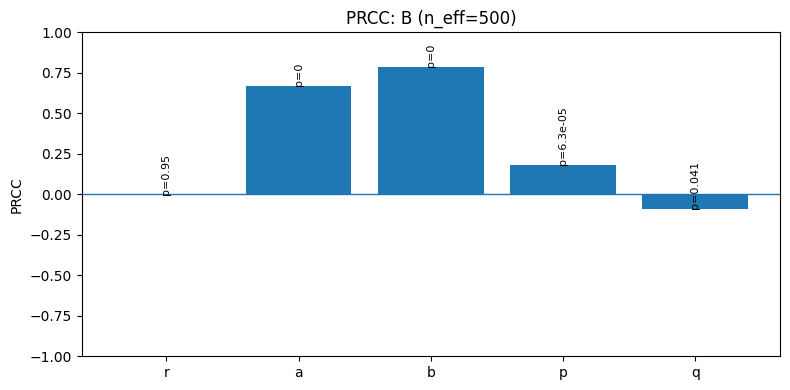

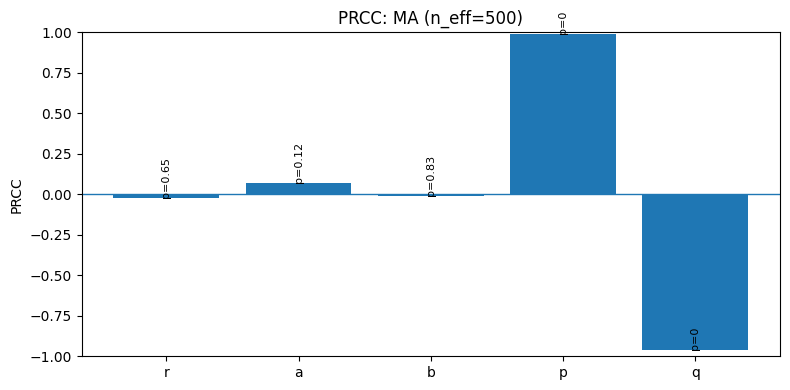

In [ ]:
r_B,  p_B,  n_eff_B  = prcc(X, B_star)
r_MA, p_MA, n_eff_MA = prcc(X, MA_star)

plot_prcc(r_B,  p_B,  "PRCC: B",  n_eff_B)
plot_prcc(r_MA, p_MA, "PRCC: MA", n_eff_MA)

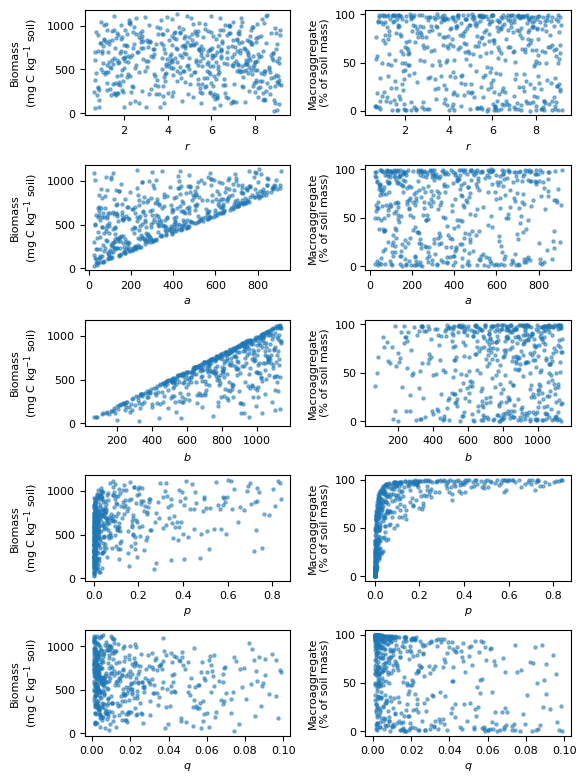

In [ ]:
df = pd.DataFrame(X, columns=param_names)
df["B_star"] = B_star
df["MA_star"] = MA_star
df["T_conv"] = T_conv

# Figure settings
mm_to_in = 1 / 25.4
fig_w_mm = 150  # User specified width
fig_h_mm = 200  # Adjust height proportionally or as needed, using a common height from other figures
figsize_inch = (fig_w_mm * mm_to_in, fig_h_mm * mm_to_in)
plt.rcParams['font.size'] = 8 # Inherit from previous settings

metrics = ["B_star", "MA_star"]

# Swap n_rows and n_cols for transposed layout
n_rows = len(param_names)
n_cols = len(metrics)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=figsize_inch,
    sharey=False
)

# Map for y-axis labels
y_label_map = {
    "B_star": 'Biomass\n(mg C kg$^{-1}$ soil)',
    "MA_star": 'Macroaggregate\n(% of soil mass)' # Label already implies percentage
}

# Iterate through parameters for rows (j_idx) and metrics for columns (i_idx)
for j_idx, param_name in enumerate(param_names):
    for i_idx, metric_name in enumerate(metrics):
        # Access subplot: axes[row_index, column_index]
        ax = axes[j_idx, i_idx]

        # Filter out NaN values for plotting
        mask = np.isfinite(df[param_name]) & np.isfinite(df[metric_name])
        x_data = df.loc[mask, param_name]
        y_data = df.loc[mask, metric_name]

        # Multiply MA_star by 100 for percentage representation
        if metric_name == "MA_star":
            y_data = y_data * 100

        ax.scatter(x_data, y_data, s=5, alpha=0.5) # Reduced point size to 5

        # Set x-axis label for each subplot (now param_name is on x-axis of each subplot)
        ax.set_xlabel(f'${param_name}$', fontsize=8) # Use f-string to embed variable and LaTeX math mode

        # Set y-axis label for all subplots in the first column
        ax.set_ylabel(y_label_map.get(metric_name, metric_name), fontsize=8)

        # Remove title: (Removed the 'if j_idx == 0:' condition for ax.set_title)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Fractal Interaction/Save/fig/grid_search_param.png', dpi=300)
plt.show()

In [ ]:
n_samples = 1000
seed = 42
X = lhs_sample(n_samples=n_samples, seed=seed)

df = pd.DataFrame(X, columns=param_names)
t_eval = np.linspace(0, 1000, 1000)

N = len(df)
B_traj = np.full((N, len(t_eval)), np.nan)
MA_traj = np.full((N, len(t_eval)), np.nan)

for i in range(N):
    # Reconstruct params dictionary for the current sample
    current_params = {}
    for j, param_name in enumerate(param_names):
        current_params[param_name] = X[i, j]

    f_ivp_current = make_system_ivp(current_params)

    # Use solve_segment with the specified settings
    try:
        solution = solve_segment(f_ivp_current, initial_state, t_eval)
        B_traj[i, :] = solution[:, 0]
        MA_traj[i, :] = solution[:, 1]
    except RuntimeError as e:
        print(f"Simulation failed for parameter set {i}: {e}")
        # Trajectories for this set will remain NaN

print(f"Traj built. Finished {N} simulations.")
# np.save("B_traj.npy", B_traj)
# np.save("MA_traj.npy", MA_traj)
# df.to_csv("summary.csv", index=False)

Traj built. Finished 1000 simulations.


In [ ]:
path = "/content/drive/MyDrive/Fractal Interaction/supplementary table1.xlsx"
df = pd.read_excel(path)

In [ ]:
df

,Macroaggregate,MBC (mg C kg-1 soil),depth,Reference
0,23.50,146.1,0-5,Hurisso et al. 2013
1,32.20,319.0,0-15,Rongzhong et al. 2019
2,52.04,244.7,30-40,Odugbenro et al. 2020
3,34.80,283.0,0-10,Sheng et al. 2020
4,56.40,241.1,NaN,Yang et al. 2022


In [ ]:
quantile_layers = [
    (0.45, 0.55),
    (0.35, 0.65),
    (0.25, 0.75),
    (0.15, 0.85),
    (0.05, 0.95)
]

def plot_density_band(ax, t, arr, quantile_layers, color="C0"):
    """
    ax : matplotlib axis
    t  : time grid
    arr: (N, T) trajectories
    """
    for i, (q_lo, q_hi) in enumerate(quantile_layers):
        lo = np.nanpercentile(arr, q_lo * 100, axis=0)
        hi = np.nanpercentile(arr, q_hi * 100, axis=0)

        alpha = 0.15 + 0.15 * (len(quantile_layers) - i)
        ax.fill_between(t, lo, hi, color=color, alpha=alpha)

/tmp/ipython-input-3909384899.py:110: UserWarning: Mismatched number of handles and labels: len(handles) = 7 len(labels) = 2
  ax_MA.legend(handles=legend_handles_MA, labels=legend_labels_MA, loc='lower right')


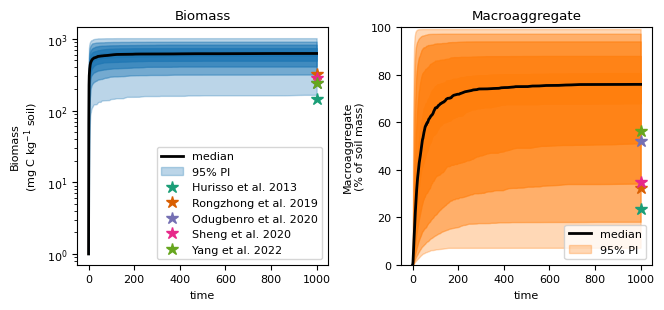

In [ ]:
t_grid = t_eval

# Figure settings
mm_to_in = 1 / 25.4
fig_w_mm = 170 # Total width
fig_h_mm = 80 # Adjusted height for 1x2 layout
figsize_inch = (fig_w_mm * mm_to_in, fig_h_mm * mm_to_in)
plt.rcParams['font.size'] = 8

# %% density-aware prediction band
fig, axes = plt.subplots(1, 2, figsize=figsize_inch, sharex=True)

# Map for y-axis labels
y_label_map = {
    "B_star": 'Biomass\n(mg C kg$^{-1}$ soil)',
    "MA_star": 'Macroaggregate\n(% of soil mass)'
}

# Get unique articles for coloring experimental data
unique_articles = df['Reference'].unique()
# Generate a color map for each unique article
# Changed colormap from 'tab10' to 'Dark2' as requested
colors = plt.colormaps.get_cmap('Dark2') # Updated to use plt.colormaps.get_cmap
article_color_map = {article: colors(i) for i, article in enumerate(unique_articles)}

# ---- B(t)
ax_B = axes[0]
plot_density_band(ax_B, t_grid, B_traj, quantile_layers, color="C0")

# 中央線（median）
B_med = np.nanpercentile(B_traj, 50, axis=0)
line_median_B, = ax_B.plot(t_grid, B_med, color="black", linewidth=2, label="median")

ax_B.set_title("Biomass")
ax_B.set_ylabel(y_label_map["B_star"])
ax_B.set_xlabel("time") # X-label on the leftmost subplot

# --- Control y-axis scale for Biomass subplot ---
# To switch back to log scale, uncomment the following lines and comment out ax_B.set_yscale("linear")
ax_B.set_yscale("log")
ax_B.yaxis.set_major_locator(LogLocator(base=10))
ax_B.yaxis.set_major_formatter(LogFormatterMathtext(base=10))
ax_B.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))
ax_B.yaxis.set_minor_formatter(LogFormatterMathtext(base=10, labelOnlyBase=False))
# ax_B.set_yscale("linear") # Set y-axis to linear scale as requested
# --------------------------------------------------


# Custom legend handles and labels for B (median, 90% band, 50% band)
legend_handles_B = [line_median_B]
legend_labels_B = ["median"]

# For (0.05, 0.95) band (i=4 in original loop, alpha = 0.30)
band_90_alpha = 0.15 + 0.15 * (len(quantile_layers) - 4) # (5-4) = 1
patch_90_B = mpatches.Patch(color="C0", alpha=band_90_alpha)
legend_handles_B.append(patch_90_B)
legend_labels_B.append('95% PI')

# ---- MA(t)
ax_MA = axes[1]
MA_traj_pct = MA_traj * 100 # Scale by 100 for percentage

plot_density_band(ax_MA, t_grid, MA_traj_pct, quantile_layers, color="C1") # Use scaled data

MA_med_pct = np.nanpercentile(MA_traj_pct, 50, axis=0) # Use scaled data
line_median_MA, = ax_MA.plot(t_grid, MA_med_pct, color="black", linewidth=2, label="median") # Use scaled data

ax_MA.set_title("Macroaggregate")
ax_MA.set_ylabel(y_label_map["MA_star"])
ax_MA.set_xlabel("time")
ax_MA.set_yscale("linear") # Set y-axis to linear scale as requested
ax_MA.set_ylim(0, 100) # Set y-axis limit from 0 to 100
# Removed log locator and formatter settings for linear scale

# Custom legend handles and labels for MA (median, 90% band, 50% band)
legend_handles_MA = [line_median_MA]
legend_labels_MA = ["median"]

# For (0.05, 0.95) band (i=4 in original loop, alpha = 0.30)
band_90_alpha = 0.15 + 0.15 * (len(quantile_layers) - 4)
patch_90_MA = mpatches.Patch(color="C1", alpha=band_90_alpha)
legend_handles_MA.append(patch_90_MA)
legend_labels_MA.append('95% PI')


# Add experimental data from df
# Assuming t=1000 is the relevant time point for experimental data
t_exp = t_eval[-1] # This corresponds to t=1000 from t_eval definition (0 to 1000, 1000 points)

for index, row in df.iterrows():
    article = row['Reference']
    current_color = article_color_map[article] # Get the unique color for the current article

    # Add to Biomass subplot (ax_B)
    mbc_value = row['MBC (mg C kg-1 soil)']
    if pd.notna(mbc_value):
        exp_line_B, = ax_B.plot(t_exp, mbc_value, '*', markersize=9, color=current_color, label=f'{article}')
        legend_handles_B.append(exp_line_B)
        legend_labels_B.append(f'{article}')

    # Add to Macroaggregate subplot (ax_MA)
    macroaggregate_value = row['Macroaggregate'] # Already in percentage based on the label
    if pd.notna(macroaggregate_value):
        exp_line_MA, = ax_MA.plot(t_exp, macroaggregate_value, '*', markersize=9, color=current_color, label=f'{article}')
        legend_handles_MA.append(exp_line_MA)
        #legend_labels_MA.append(f'{article}')

# Update legends with experimental data
ax_B.legend(handles=legend_handles_B, labels=legend_labels_B, loc='lower right')
ax_MA.legend(handles=legend_handles_MA, labels=legend_labels_MA, loc='lower right')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Fractal Interaction/Save/fig/prediction_interval.png', dpi=300)
plt.show()